## TRABAJO FINAL MACHINE LEARNING
## John Steven Ceballos Agudelo


El problema de hoy consiste en realizar un modelo de predicción acerca de una transacción en un e-commerce es fraudulenta o no,
utilizando un dataset que contiene 19 variables (A a S) más una columna de
monto de la transacción, y la variable de respuesta denominada "fraude",
que indica si una transacción es fraudulenta (1) o no (0).

Para poder trabajar con nuestro dataset, importaremos las siguientes librerias:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score

Leemos nuestro conjunto de datos proporcionados por el profesor y lo nombramos `data`

In [2]:
data = pd.read_csv("data.csv")

Veamos un poco de nuestro dataset...

In [3]:
data

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,7.25,37.51,1
1,0,10,29014.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,3,0.00,0.00,11.66,8.18,1
2,0,7,92.0,0,1,0.000,0.0,0,1,UY,...,0,3,1,0,2,0.00,0.00,86.97,13.96,1
3,9,16,50269.0,0,0,0.000,0.0,0,0,UY,...,0,3,1,0,5,0.00,0.00,2.51,93.67,1
4,0,8,8180.0,0,0,0.000,0.0,0,0,UY,...,0,1,1,0,1,0.00,0.00,25.96,135.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0,3,63302.0,0,1,0.500,0.0,0,0,BR,...,1,1,1,0,1,0.00,0.00,85.73,132.17,1
16876,0,12,825.0,0,0,0.000,0.0,0,0,BR,...,1,1,1,0,5,0.00,0.00,12.50,26.34,1
16877,1,3,81067.0,0,0,0.000,0.0,0,0,BR,...,0,1,1,0,1,0.00,0.00,24.16,195.63,1
16878,0,9,398372.0,0,0,0.000,0.0,0,0,BR,...,0,2,1,0,1,0.00,0.00,29.00,36.97,1


Vemos el tamaño de nuestras filas y columnas pertenecientes al dataset

In [4]:
print(data.shape)
print(data.columns)

(16880, 21)
Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'Monto', 'Fraude'],
      dtype='object')


Eliminamos espacios en blanco, cambiamos mayusculas por minusculas y reemplazamos espacios en blanco por guiones bajos para facilitar el trabajo de las features

In [5]:
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

Revisemos cuantos valores nulos hay presentes en nuestro dataset

In [6]:
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_data[missing_data['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
k,12864,76.208531
c,3197,18.939573


Como podemos observar la feature `k` y la feature `c` cuentan con valores nulos, en especial `k` por lo tanto esta feature no la incluiremos en el modelo,mas adelante trataremos la feature `c`

In [7]:
data.drop(['k'],axis=1,inplace=True)

Revisemos los valores unicos de nuestro dataset

In [8]:
data.nunique()

a           21
b           21
c         9782
d           31
e           23
f          153
g          106
h           14
i           17
j           19
l            8
m           11
n           10
o            4
p           14
q          605
r          109
s         6467
monto     9616
fraude       2
dtype: int64

Hay features como `c` , `s` , `monto` que tienen muchos valores unicos pero pueden ser importantes en el modelo por lo tanto los vamos a incluir

Usaremos `.info()` para ver la cantidad de valores nulos y el tipo de dato que es cada feature

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       16880 non-null  int64  
 1   b       16880 non-null  int64  
 2   c       13683 non-null  float64
 3   d       16880 non-null  int64  
 4   e       16880 non-null  int64  
 5   f       16880 non-null  float64
 6   g       16880 non-null  float64
 7   h       16880 non-null  int64  
 8   i       16880 non-null  int64  
 9   j       16880 non-null  object 
 10  l       16880 non-null  int64  
 11  m       16880 non-null  int64  
 12  n       16880 non-null  int64  
 13  o       16880 non-null  int64  
 14  p       16880 non-null  int64  
 15  q       16880 non-null  object 
 16  r       16880 non-null  object 
 17  s       16880 non-null  float64
 18  monto   16880 non-null  object 
 19  fraude  16880 non-null  int64  
dtypes: float64(4), int64(12), object(4)
memory usage: 2.6+ MB


Como podemos observar estamos contando con 4 variables categoricas, lo cual esta mal ya que `new_q`, `new_r` , `new_monto` son numericas, la unica categoriaca es `j` que representa los prefijos de los paises.

El problema que esta sucediendo es que tras revisar el dataset encontre que hay valores separados por `,` por lo tanto las toma como tipo object.

Para solucionar esto usaremos la función de pandas `to_numeric` para convertir las cadenas de texto a numeros

In [10]:
data['q'] = pd.to_numeric(data['q'].str.replace(',', ''), errors='coerce')
data['r'] = pd.to_numeric(data['r'].str.replace(',', ''), errors='coerce')
data['monto'] = pd.to_numeric(data['monto'].str.replace(',', ''), errors='coerce')

Veamos un poco de cada feature y sus estadisticas

In [11]:
data.describe()

,a,b,c,d,e,f,g,h,i,l,m,n,o,p,q,r,s,monto,fraude
count,16880.000000,16880.000000,13683.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000,16880.000000
mean,0.309242,7.645379,39235.339984,0.198697,0.433709,0.015878,0.005200,0.050296,0.144076,0.432346,1.544135,1.091765,0.009419,1.630865,8.445394,1.994921,29.127720,161.837033,0.273164
std,1.094064,4.686494,91045.252879,2.042959,1.537297,0.098730,0.059419,0.531060,0.824761,0.663860,1.022385,0.408081,0.116606,1.088286,74.367729,38.222485,26.510548,275.499961,0.445597
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.050000,0.000000
25%,0.000000,4.000000,1172.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,9.560000,33.807500,0.000000
50%,0.000000,7.000000,6173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,20.640000,81.645000,0.000000
75%,0.000000,11.000000,26888.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,39.212500,193.440000,1.000000
max,30.000000,20.000000,617324.000000,180.000000,45.000000,1.000000,1.000000,21.000000,24.000000,7.000000,13.000000,10.000000,3.000000,41.000000,2274.670000,2025.720000,99.970000,12538.440000,1.000000


* La columna `b` tiene un mínimo de -1, lo cual podría indicar un valor erróneo o un valor de entrada incorrecto, ya que la media y la mayoría de los valores parecen estar en un rango positivo.
* La columna `s` también muestra un valor mínimo de -1.



Contemos cuantos valores tienen -1

In [12]:
print("Valores de -1 en la columna 'b':", data['b'].value_counts().get(-1, 0))
print("Valores de -1 en la columna 's':", data['s'].value_counts().get(-1, 0))

Valores de -1 en la columna 'b': 125
Valores de -1 en la columna 's': 136


Observamos como pocos datos tienen valor `-1` por lo tanto los reemplazaremos por la mediana para asi evitarnos problemas con estas features

In [13]:
# Calcula la mediana de las columnas 'b' y 's' excluyendo los valores -1
median_b = data.loc[data['b'] != -1, 'b'].median()
median_s = data.loc[data['s'] != -1, 's'].median()

# Reemplaza los valores -1 con la mediana calculada
data['b'] = data['b'].replace(-1, median_b)
data['s'] = data['s'].replace(-1, median_s)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       16880 non-null  int64  
 1   b       16880 non-null  int64  
 2   c       13683 non-null  float64
 3   d       16880 non-null  int64  
 4   e       16880 non-null  int64  
 5   f       16880 non-null  float64
 6   g       16880 non-null  float64
 7   h       16880 non-null  int64  
 8   i       16880 non-null  int64  
 9   j       16880 non-null  object 
 10  l       16880 non-null  int64  
 11  m       16880 non-null  int64  
 12  n       16880 non-null  int64  
 13  o       16880 non-null  int64  
 14  p       16880 non-null  int64  
 15  q       16880 non-null  float64
 16  r       16880 non-null  float64
 17  s       16880 non-null  float64
 18  monto   16880 non-null  float64
 19  fraude  16880 non-null  int64  
dtypes: float64(7), int64(12), object(1)
memory usage: 2.6+ MB


Como podemos observar, la feature `c` cuenta con valores nulos por lo tanto para rellenarlos usramos el metodo de KNN el cual puede ser un poco costoso computacionalmente pero no es un gran poblema para este modelo ya que no son tantos datos.

Ademas anteriormente intente rellenarlos con otros parametros como la moda, mediana, etc... pero nos generaban una mayor varianza

In [15]:
imputer = KNNImputer(n_neighbors=5)
data[['c']] = imputer.fit_transform(data[['c']])
print(data['c'].isnull().sum())

0


Revisemos como se da la distribucion de las features...

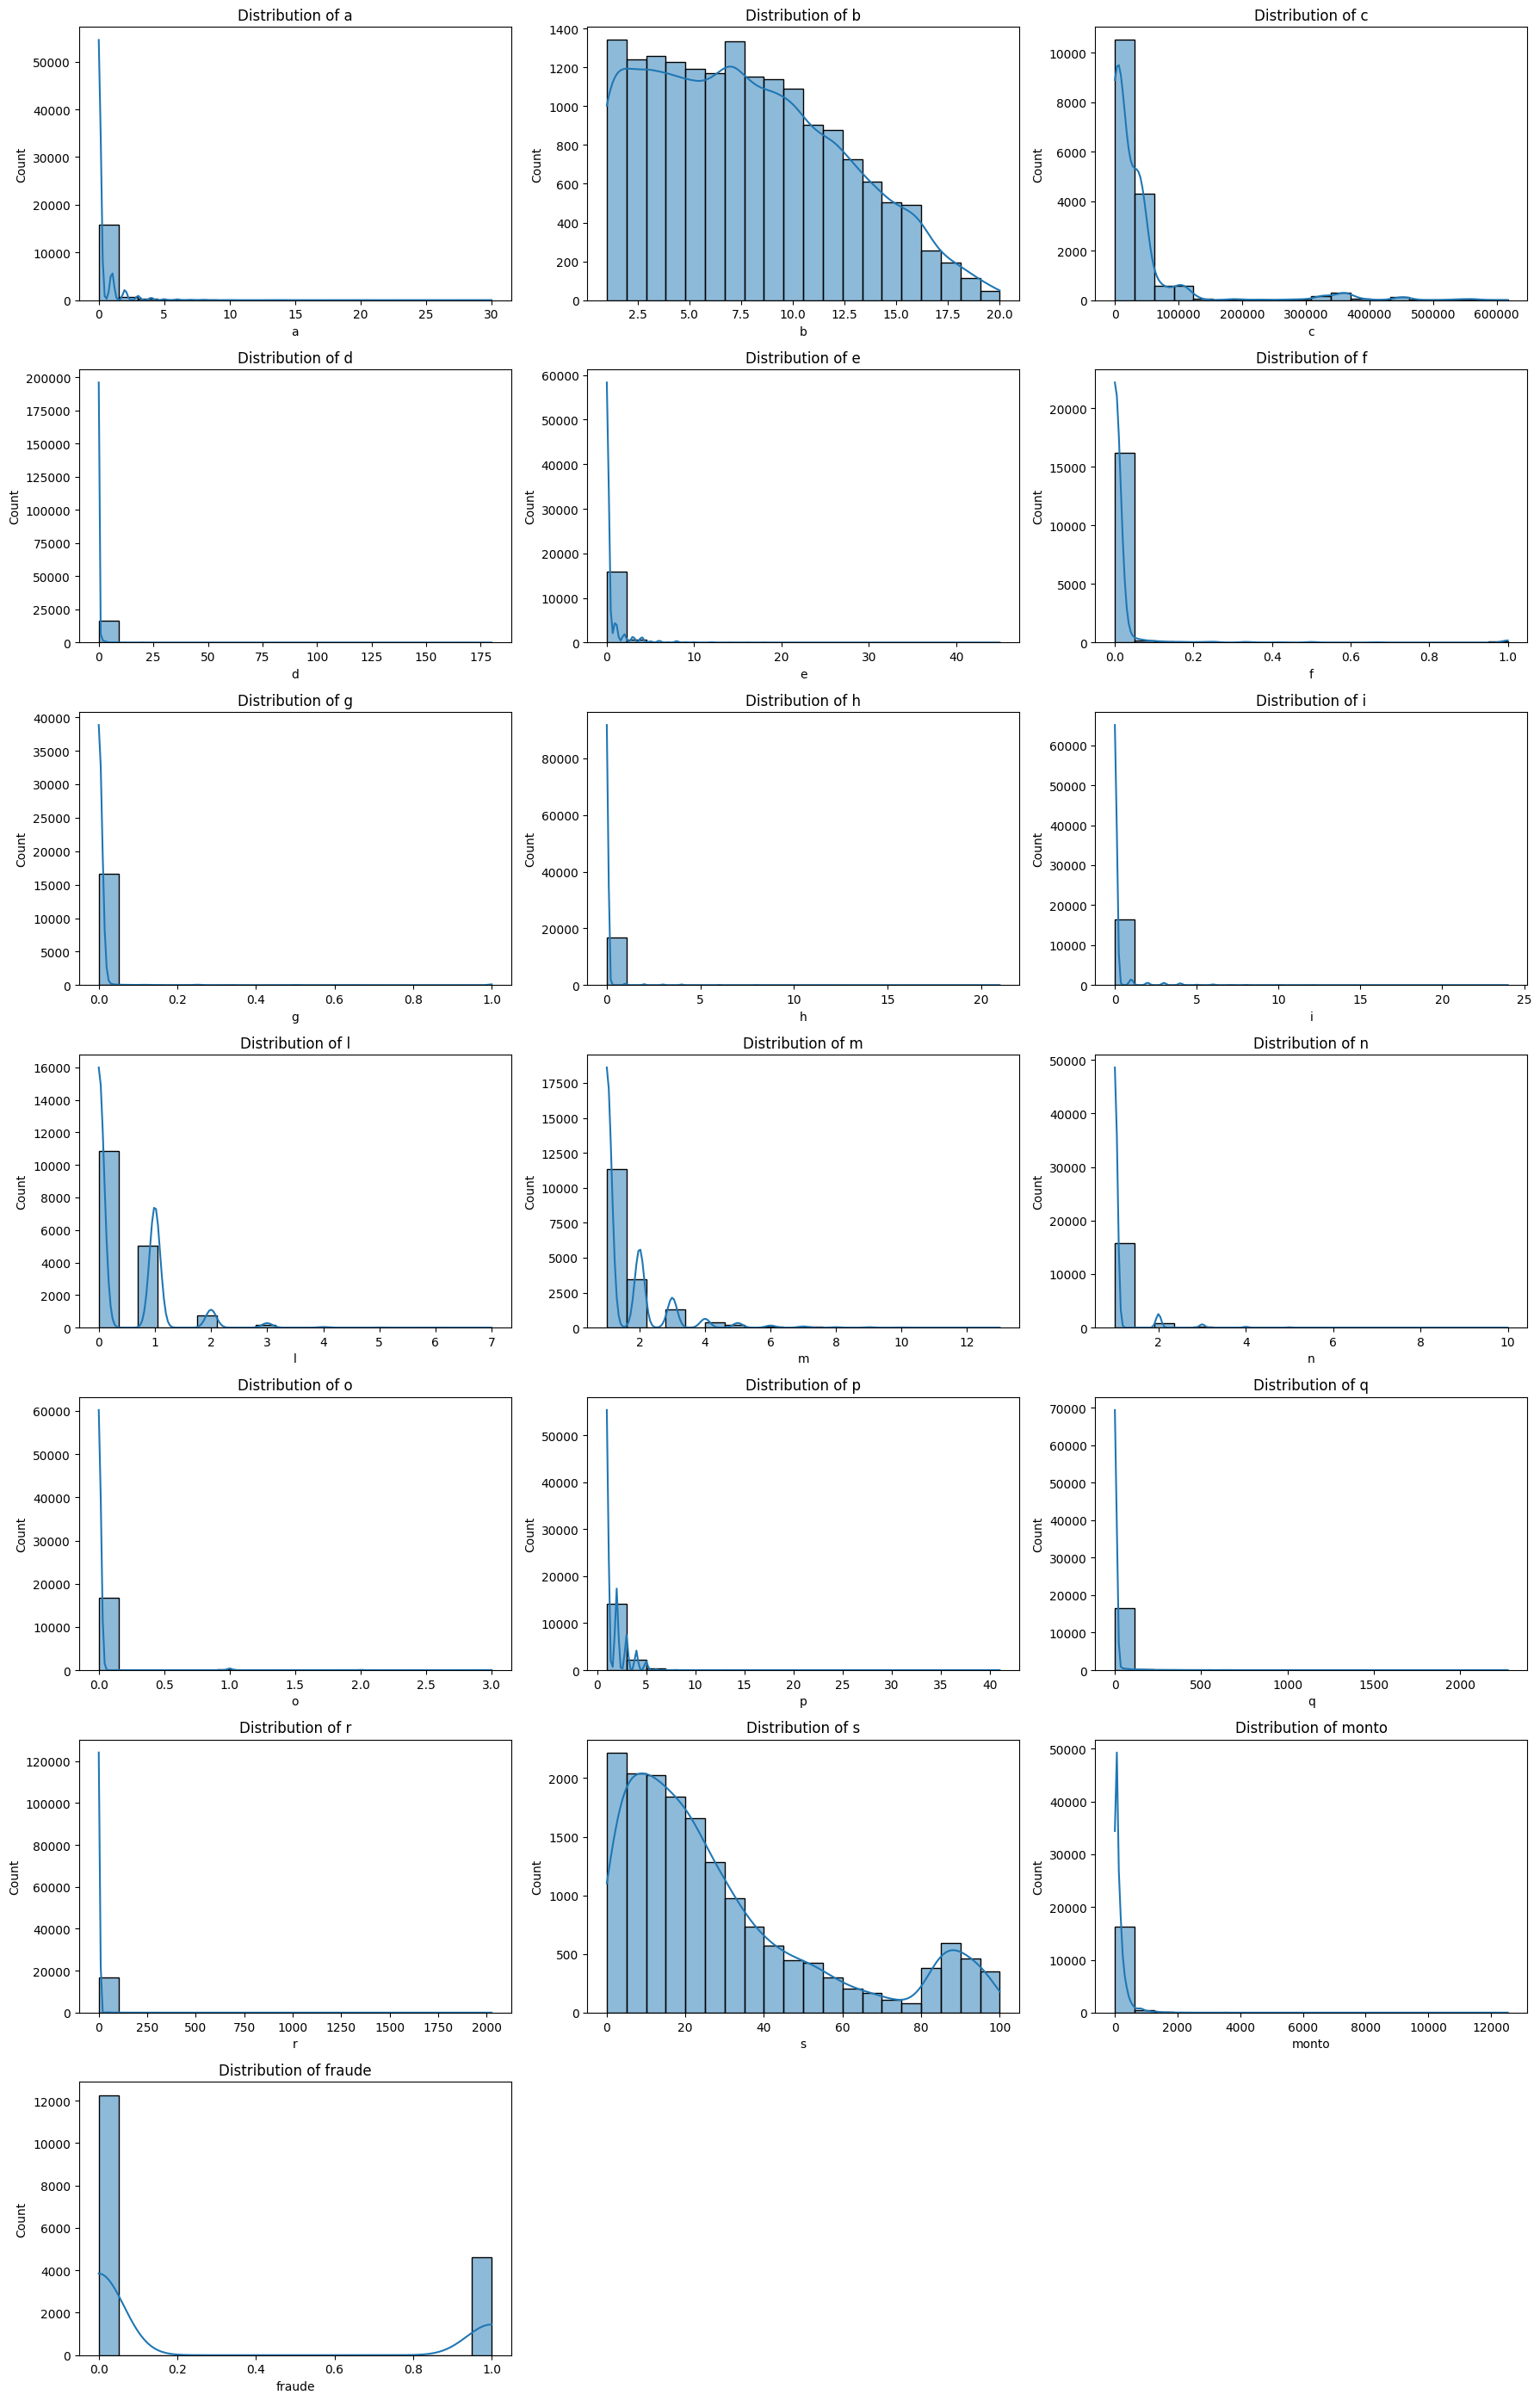

In [16]:
num_cols = 3
num_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_rows = (len(num_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 4))
axes = axes.flatten()
for i, column in enumerate(num_columns):
    sns.histplot(data[column], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

De las graficas podemos concluir lo siguiente:

* Distribución Sesgada: La mayoría de las variables ( `a, c, d, e, f, g, h, i, l, m, n, o, p, fraude, new_q, new_r, new_monto`) presentan una fuerte acumulación de valores en la parte baja del rango, indicando una distribución sesgada. Esto podría requerir transformaciones para normalizar los datos y mejorar la precisión del modelo.

* Distribución Más Uniforme: Variables como `b` y `s` tienen distribuciones más esparcidas.

Tambien realizemos diagramas de cajas y bigotes para detectar posibles outliers

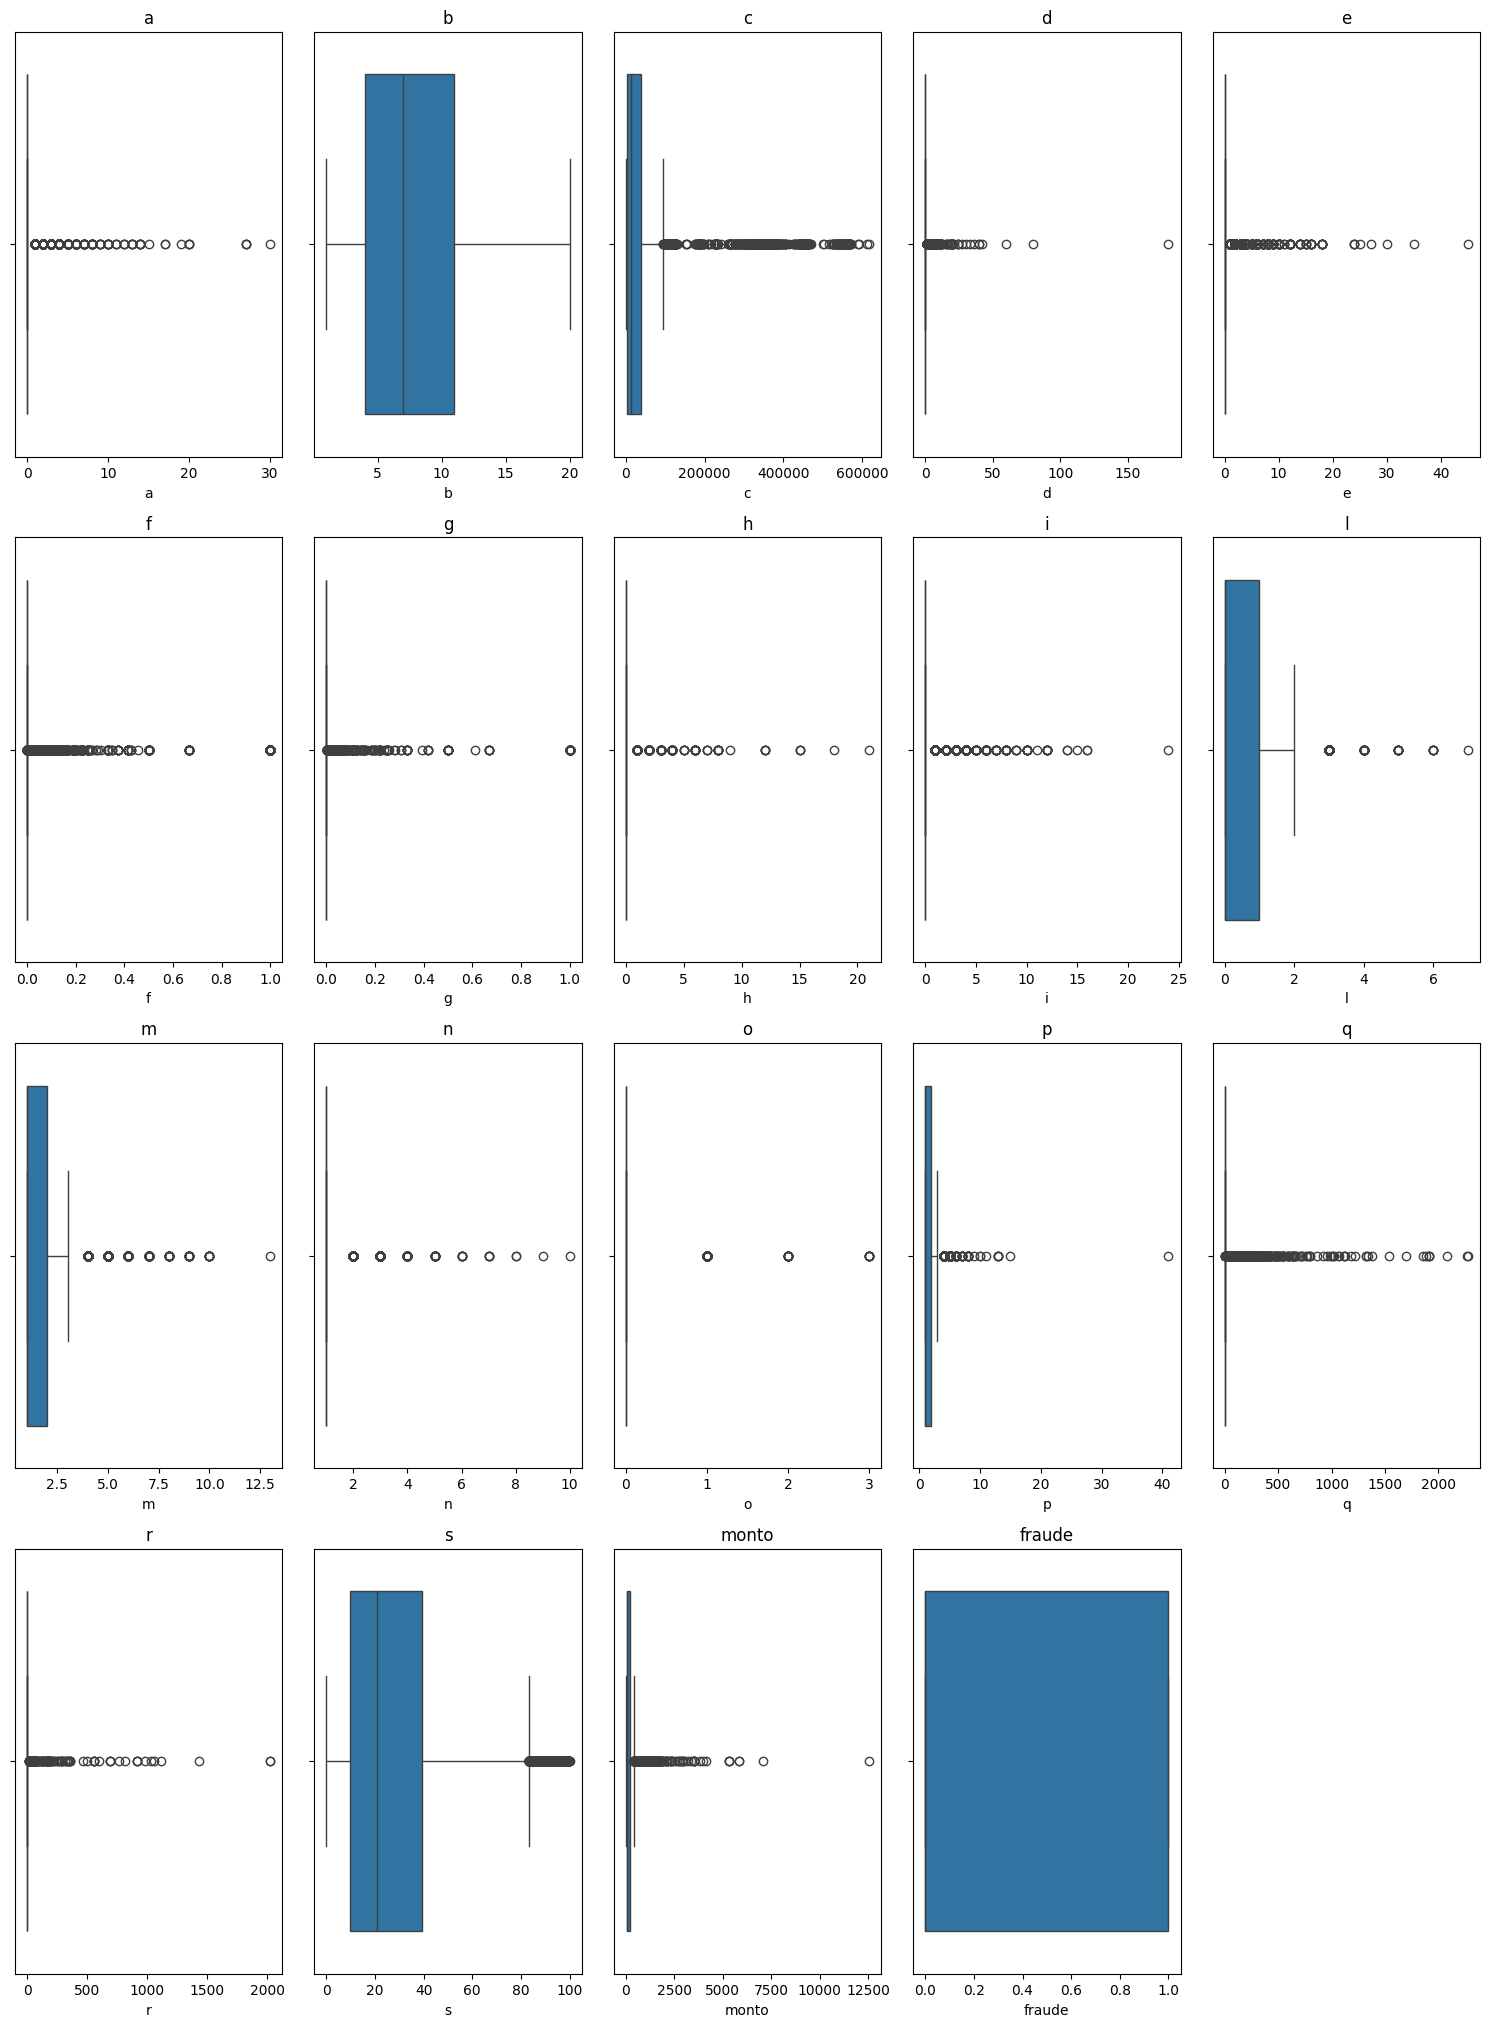

In [17]:
num_cols = 5
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(numeric_columns)
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Como podemos observar en nuestro dataset hay una alta presencia de outliers por lo tanto seria bueno intentar reducir estos para mejorar el modelo

Realizaremos una transformacion de raiz cuadrada a nuestro dataset para de esta manera ver si reducen la cantidad de outliers de nuestro dataset, exluiremos la variable objetivo ya que son solo `0` y `1`.

In [18]:
numerical_cols = data.select_dtypes(include=[np.number]).columns.drop('fraude')
data[numerical_cols] = np.sqrt(data[numerical_cols])

Realizemos graficos nuevamente para verificar si hubo en cambio en los outliers

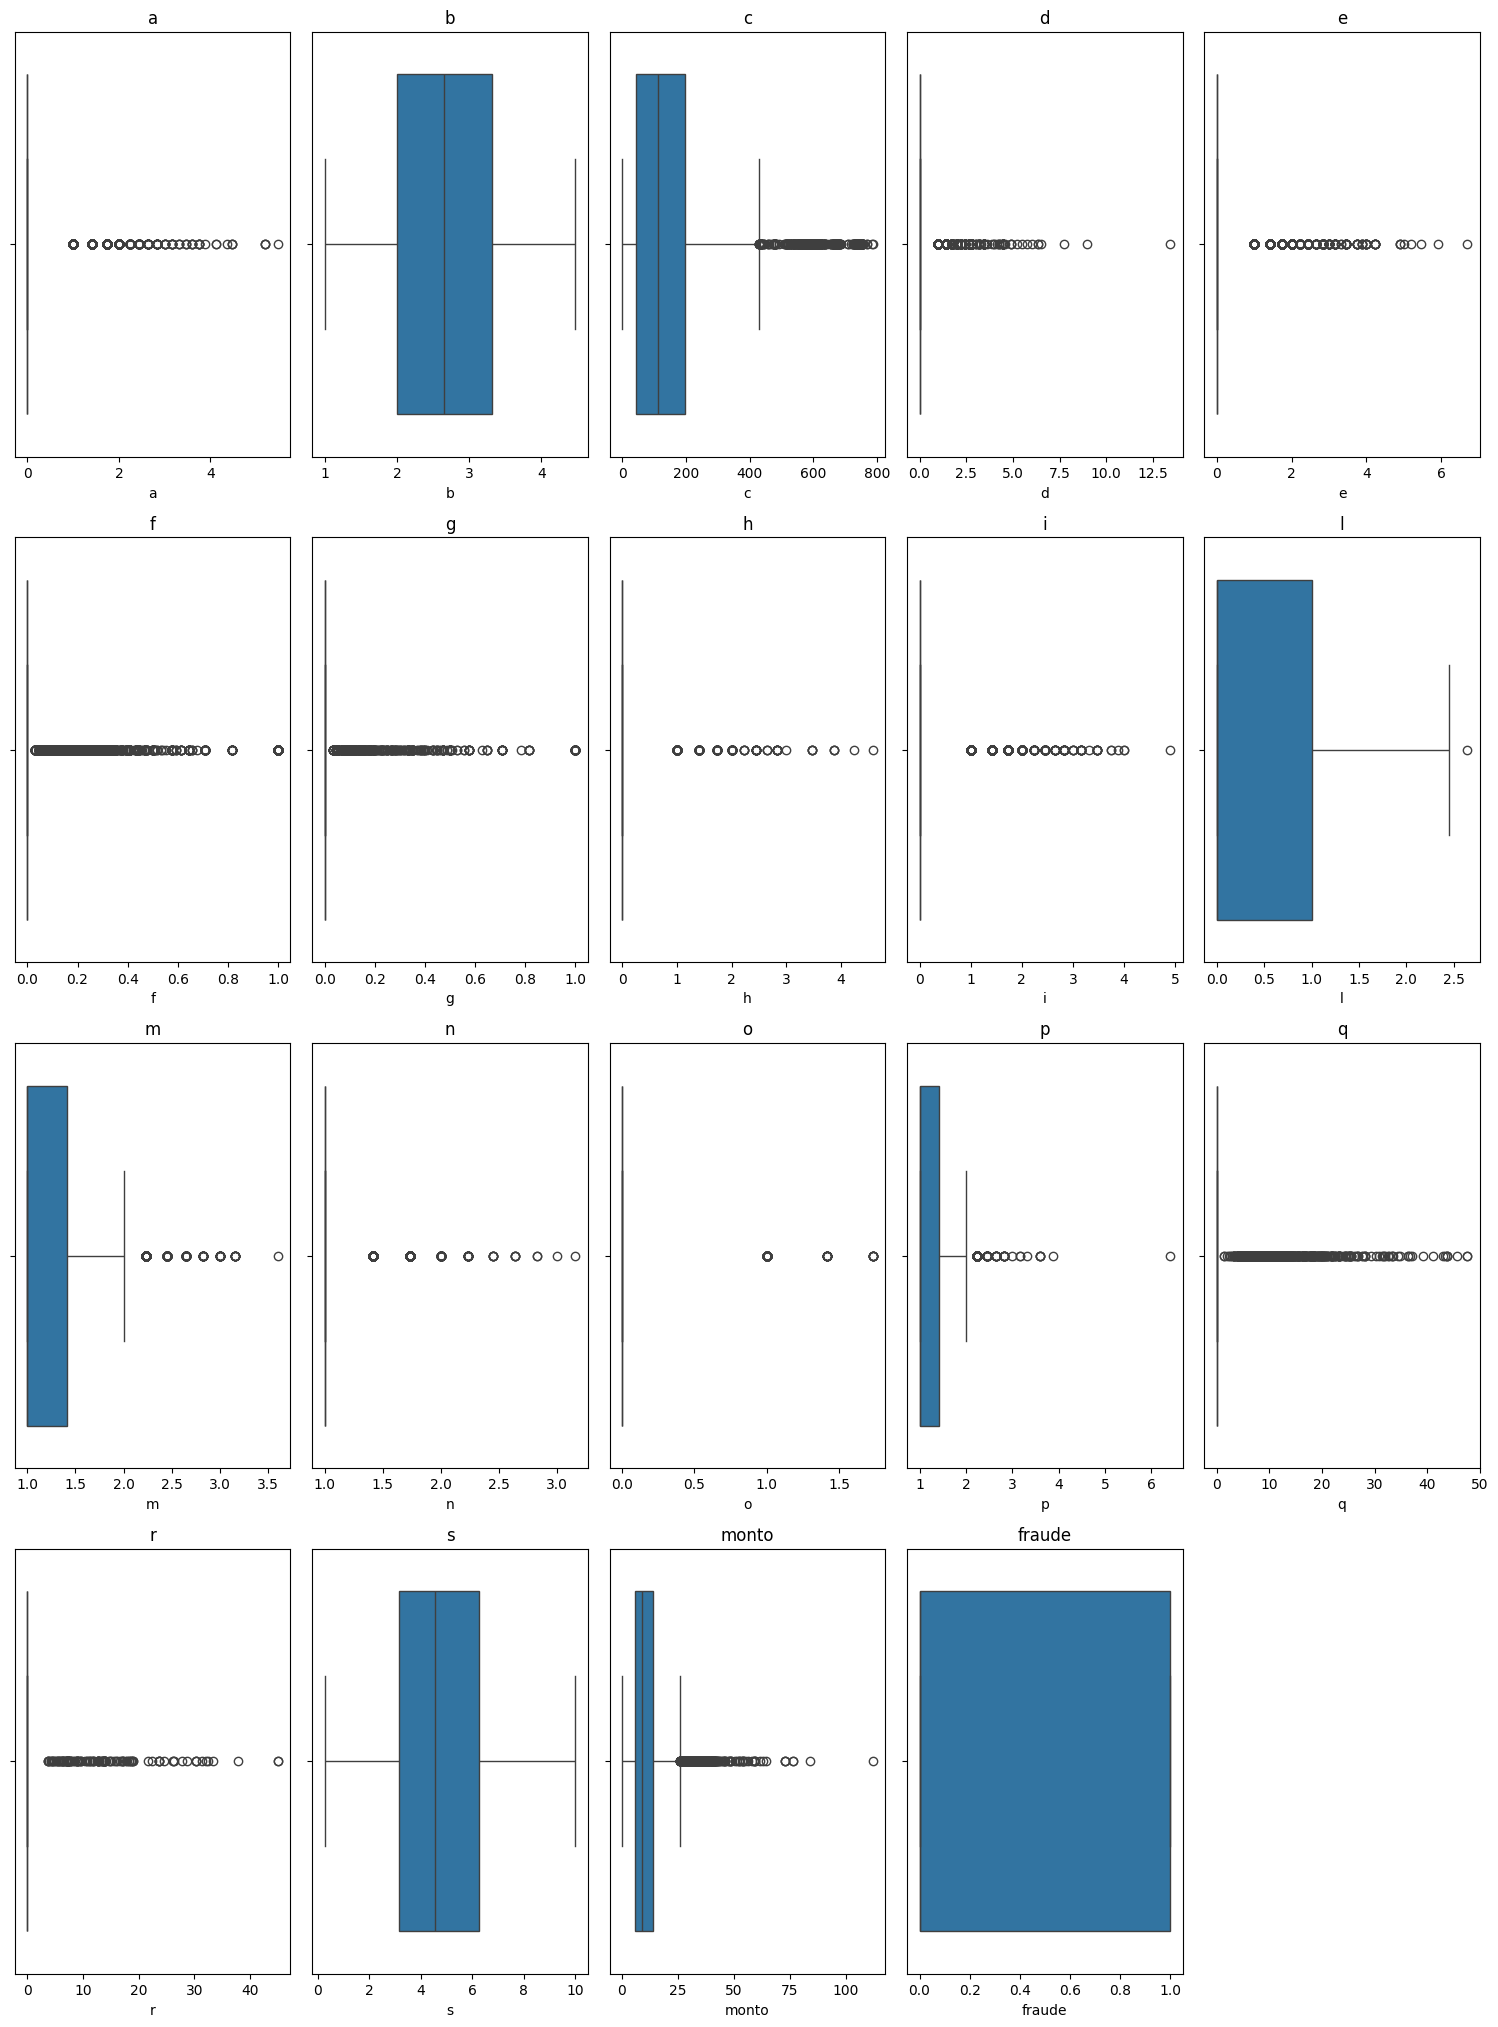

In [19]:
num_cols = 5
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(numeric_columns)
num_rows = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    sns.boxplot(x=data[column], ax=axes[i])
    axes[i].set_title(column)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

En varias features hubo un buen cambio y se redujeron muchos outliers, pero sigue habiendo presencia de estos en las features.

Revisemos nuestra variable objetivo

fraude
0    12269
1     4611
Name: count, dtype: int64


<Axes: xlabel='fraude'>

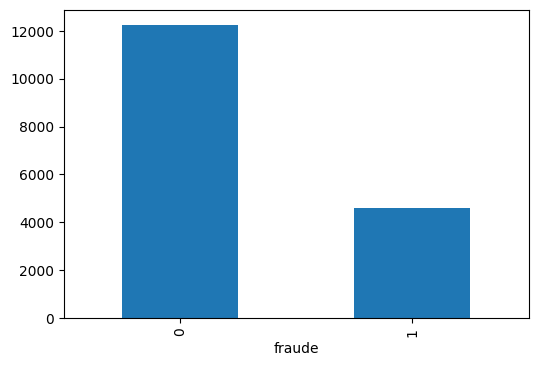

In [20]:
print(data['fraude'].value_counts())
data['fraude'].value_counts().plot(kind='bar' , figsize = (6,4))

Aunque hay una diferencia entre una y otra, no esta tan desbalanceada por lo tanto es positivo ya que no tendremos que usar tantos modelos para mejorar clases desbalanceadas

Analisemos nuestra variable categorica

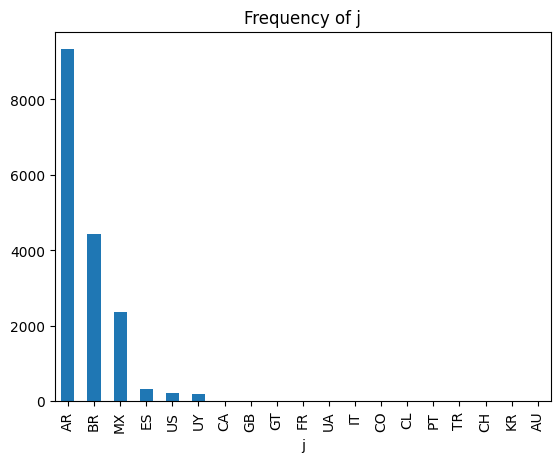

In [21]:
for column in data.select_dtypes(include=['object']).columns:
    plt.figure()
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {column}')
    plt.show()

Como podemos observar la mayor cantidad de datos se encuentra en los paises de `AR` , `BR` , `MX` , `ES` , `US` , `UY`, en los otros paises practimante no hay presencua de valores

Por lo tanto solo dejaremos estos paises para evitar ruido en nuestro modelo

In [ ]:
#paises_significativos = ['AR', 'BR', 'MX', 'ES', 'US', 'UY']
#data = data[data['j'].isin(paises_significativos)]

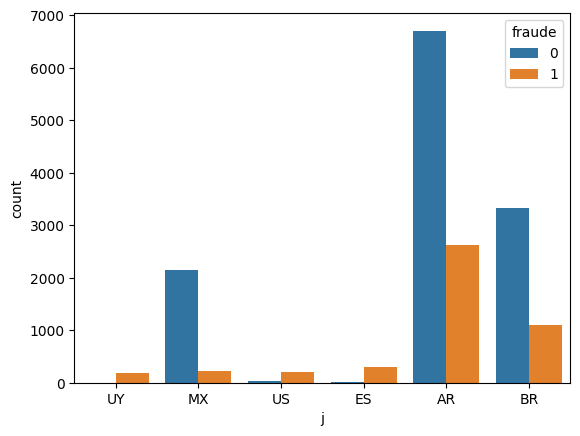

<Figure size 400x300 with 0 Axes>

In [23]:
for column in data.select_dtypes(include=['object']).columns:
    sns.countplot(x=column, hue='fraude', data=data)
    plt.figure(figsize=(4, 3))
    plt.show()

* Argentina (AR): Tiene la mayor cantidad de casos tanto de fraude como de no fraude, con más de 6000 casos de no fraude y alrededor de 3000 casos de fraude. Esto podría sugerir que Argentina es un punto crítico para la detección de fraudes.

* Brasil (BR): También muestra un número significativo de casos de no fraude (alrededor de 3000) y una cantidad menor de casos de fraude (alrededor de 1000). Similar a Argentina, Brasil es otro país con una actividad considerable que podría necesitar atención en la gestión de fraudes.

* México (MX): Tiene una cantidad considerable de casos de no fraude (alrededor de 2000) y una cantidad muy baja de casos de fraude. México parece tener un perfil de fraude más bajo en comparación con su volumen de transacciones.

* Uruguay (UY), Estados Unidos (US) y España (ES): Estos países tienen cantidades muy bajas de casos tanto de fraude como de no fraude, con menos de 500 casos en cada categoría. Esto podría indicar que en estos países la actividad de fraude es menos prevalente o que las transacciones en general son menos frecuentes.

Ya para los paises que nos quedaron realizaremos one hot encoding para poder tratar con esta variable numerica

In [24]:
def apply_one_hot_encoding(data, columns):
    for column in columns:
        dummies = pd.get_dummies(data[column], prefix=column).astype(int)
        data = data.join(dummies).drop([column], axis=1)
    return data

one_hot_columns = ["j"]

data = apply_one_hot_encoding(data, one_hot_columns)

Contamos con 25 features para nuestro modelo

In [25]:
data.shape

(16847, 25)

Realizaremos graficas de las features vs la variable objetivo para identificar patrones

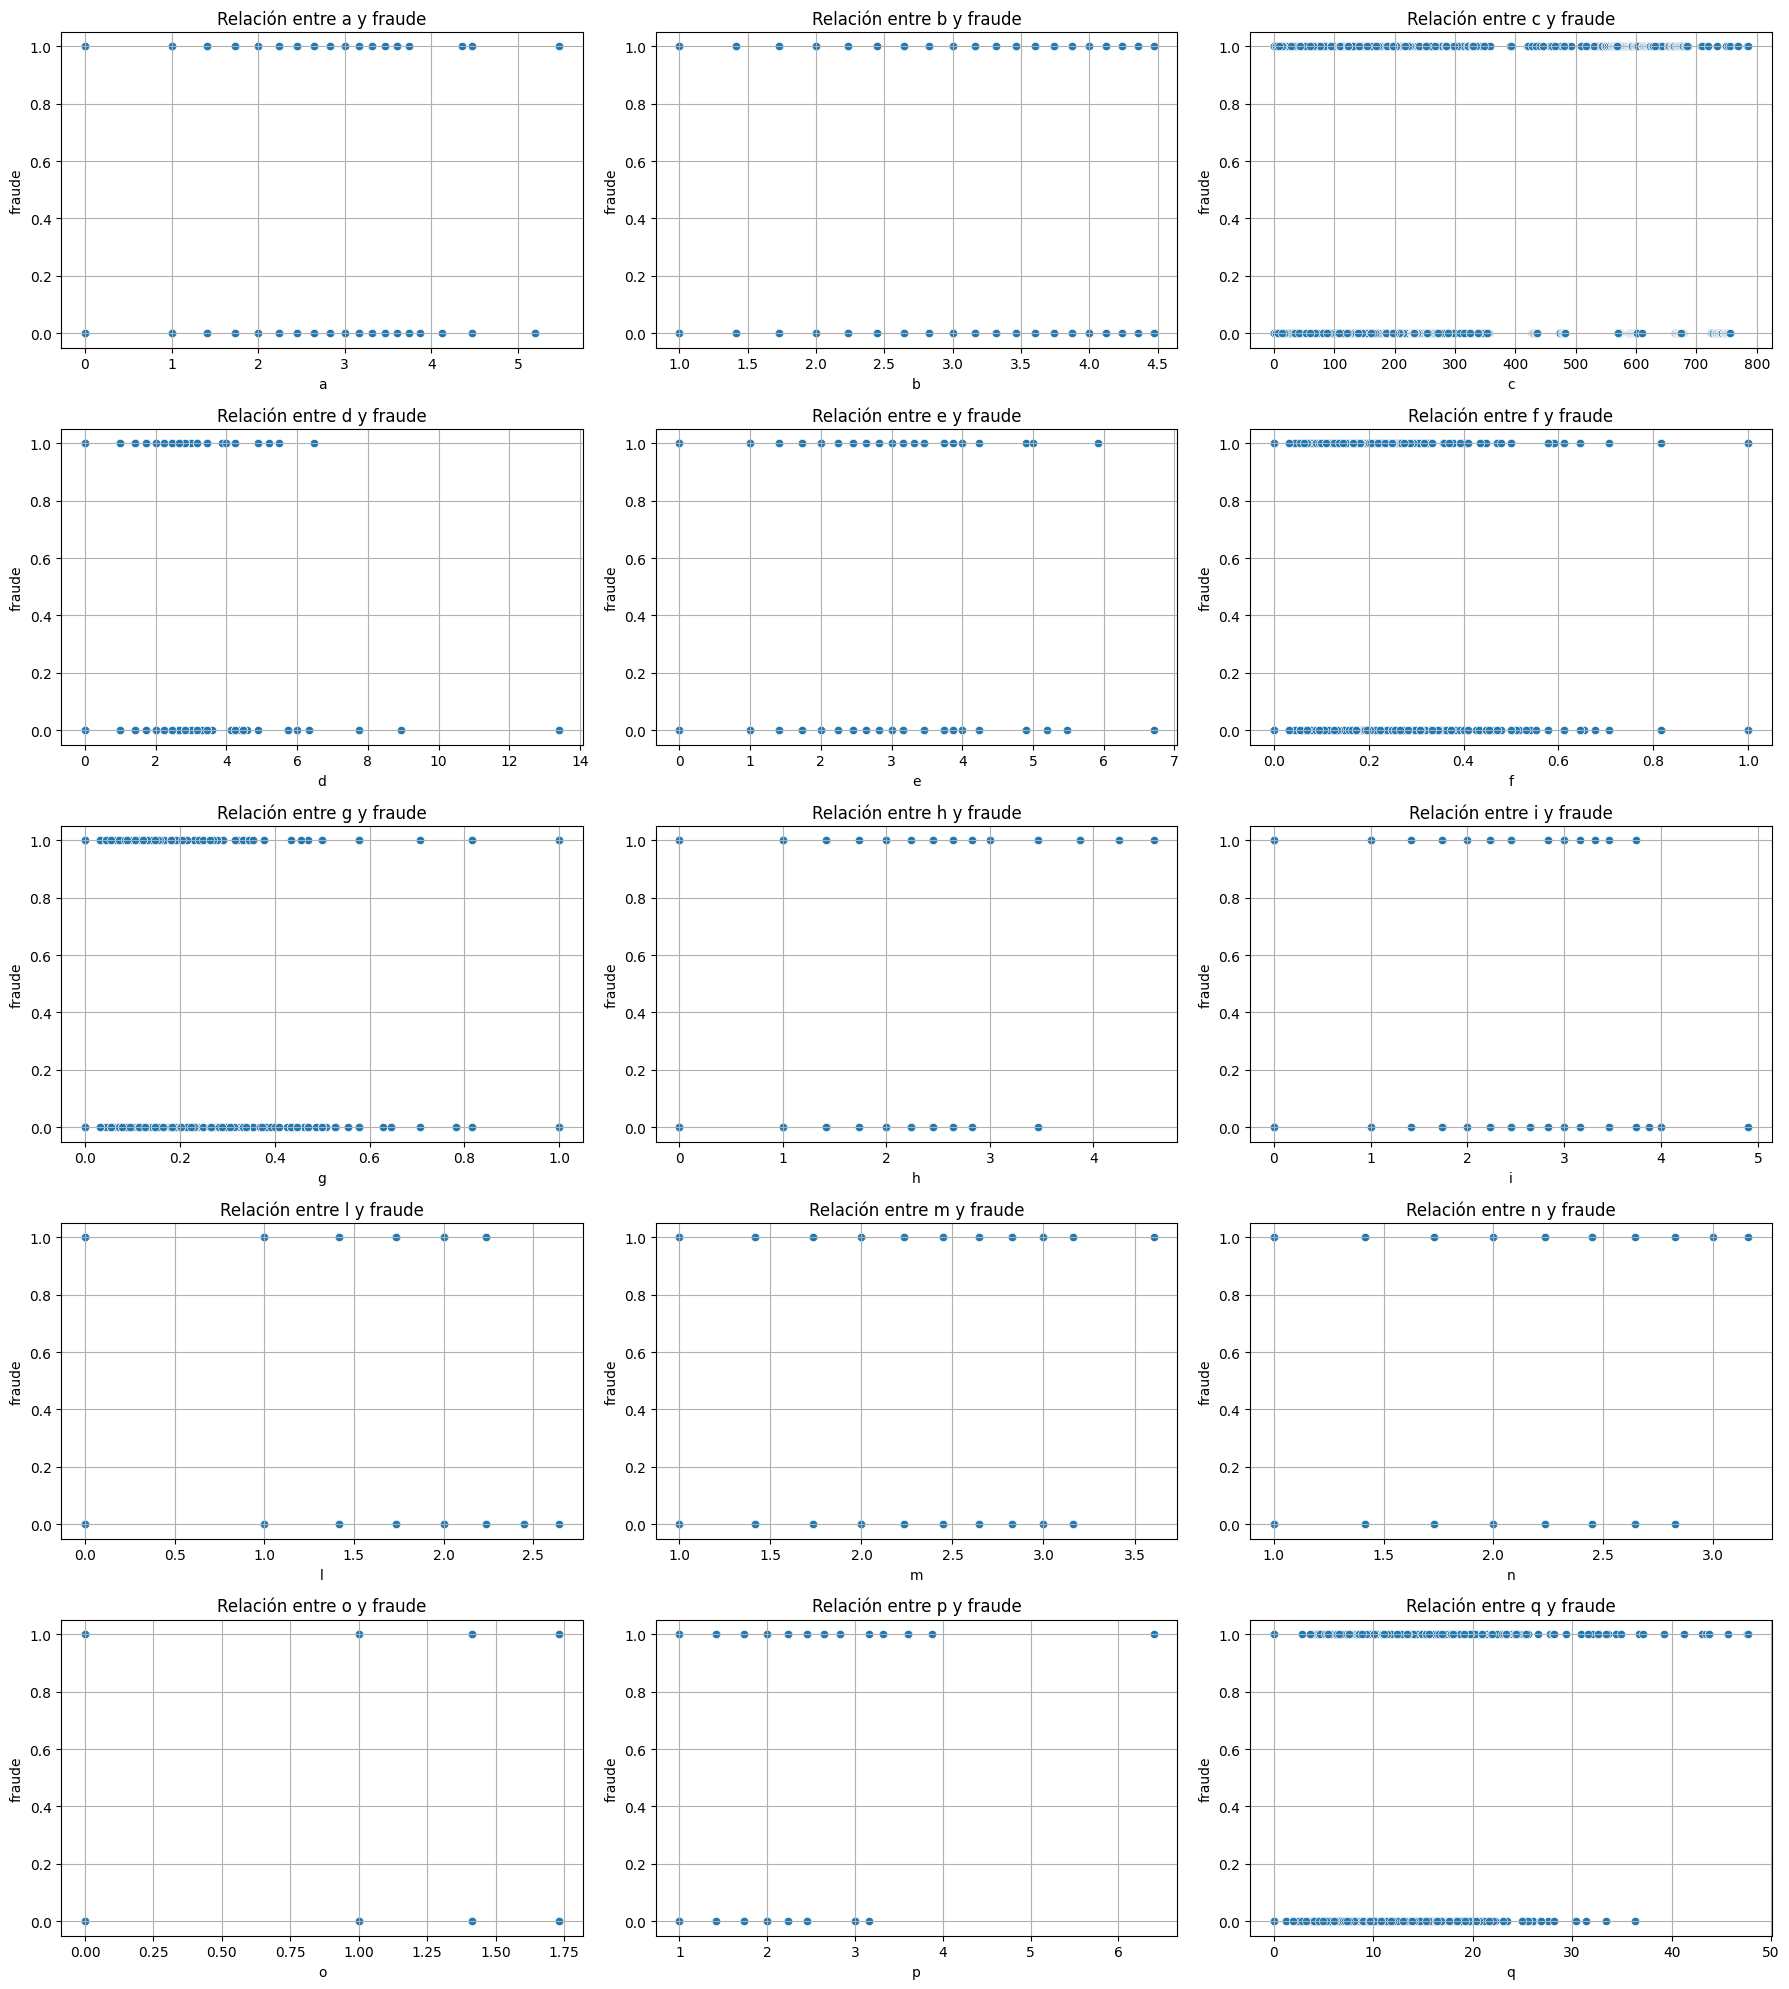

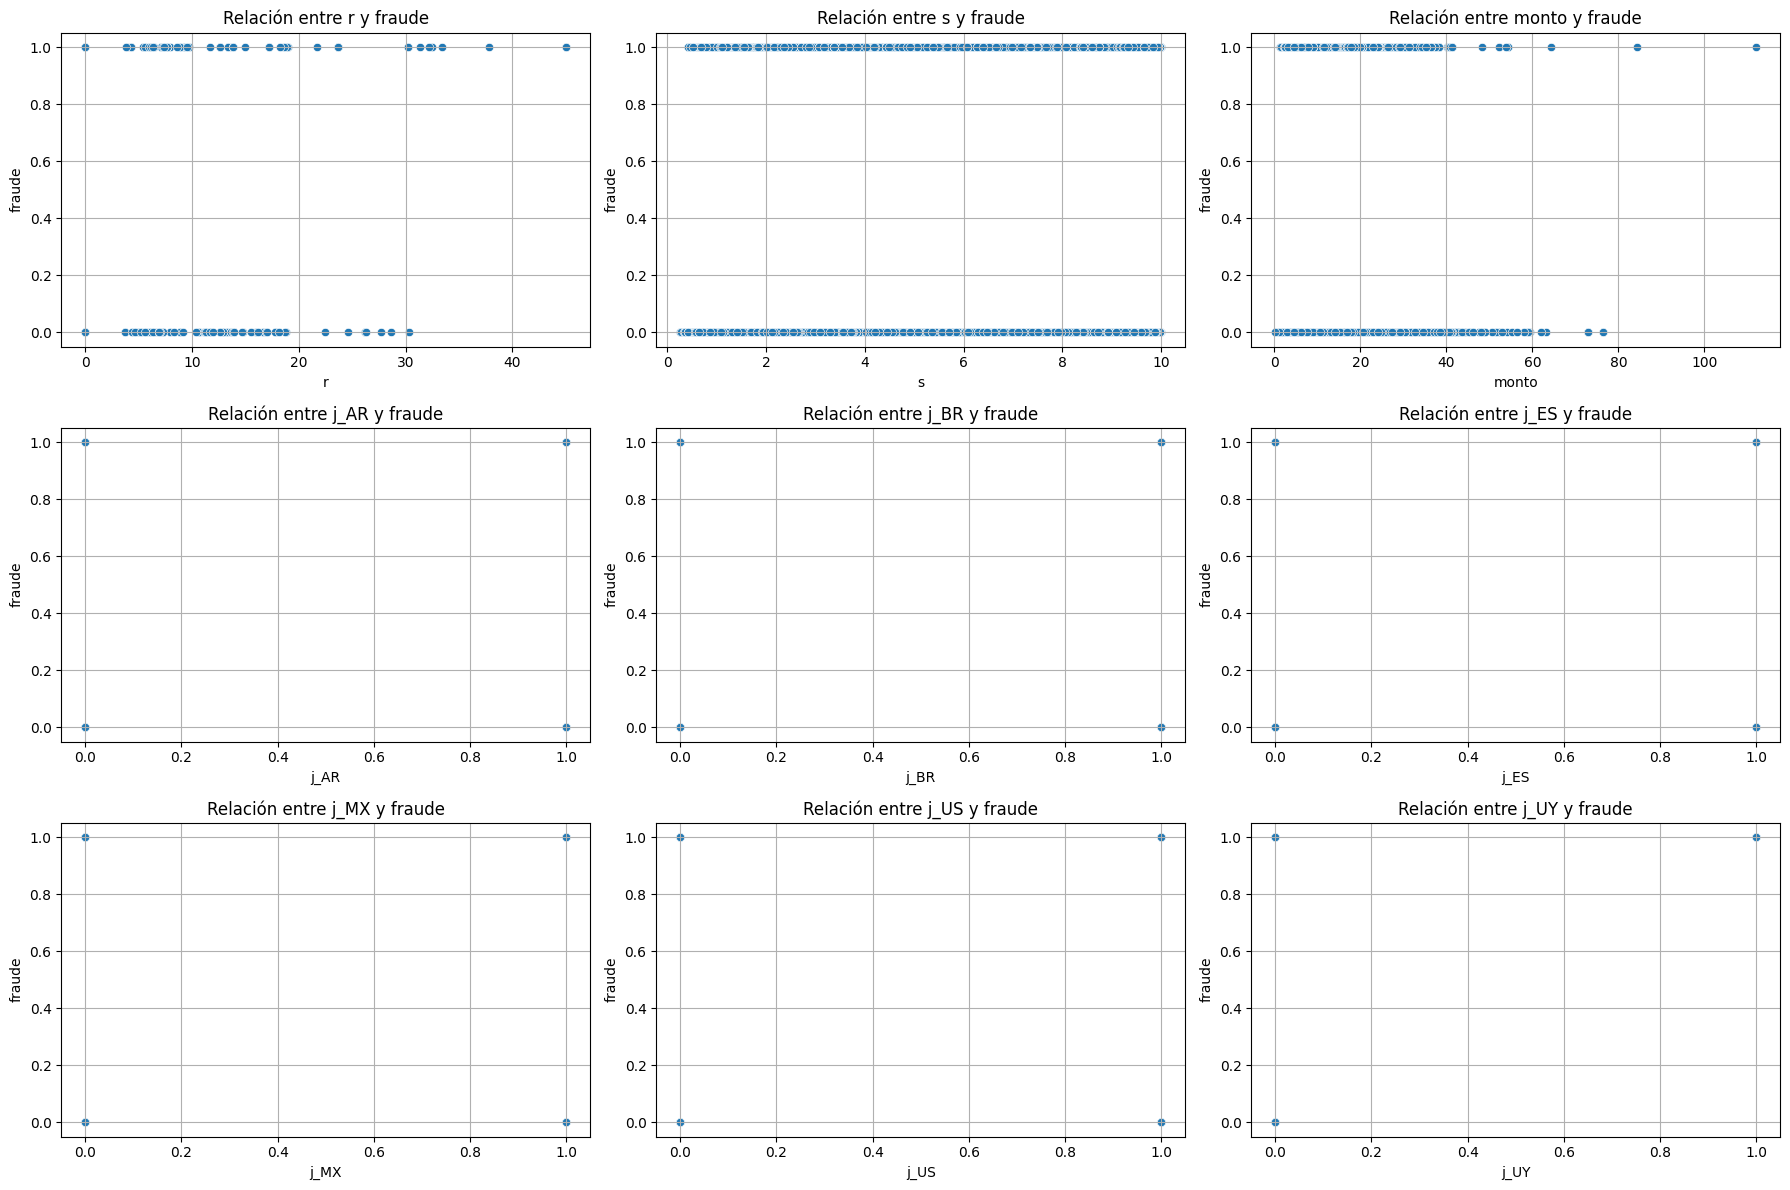

In [26]:
def plot_scatterplots_numerical_vs_target(data, target, plots_per_figure=15):
    # Seleccionar variables numéricas
    numerical_data = data.select_dtypes(include=['float64', 'int64'])

    # Excluir la variable objetivo de las variables a graficar
    columns_to_plot = [col for col in numerical_data.columns if col != target]

    # Calcular número de figuras necesarias
    num_plots = len(columns_to_plot)
    num_figures = int(np.ceil(num_plots / plots_per_figure))

    for fig_num in range(num_figures):
        # Calcular cuántos plots irán en esta figura
        start_idx = fig_num * plots_per_figure
        end_idx = min((fig_num + 1) * plots_per_figure, num_plots)
        current_columns = columns_to_plot[start_idx:end_idx]

        # Configurar el número de filas y columnas para esta figura
        num_cols = min(3, len(current_columns))
        num_rows = int(np.ceil(len(current_columns) / num_cols))

        # Crear nueva figura
        plt.figure(figsize=(18, num_rows * 4))

        for i, column in enumerate(current_columns):
            plt.subplot(num_rows, num_cols, i + 1)
            sns.scatterplot(x=data[column], y=data[target])
            plt.title(f'Relación entre {column} y {target}')
            plt.xlabel(column)
            plt.ylabel(target)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

plot_scatterplots_numerical_vs_target(data, 'fraude')

No parece haber una relación clara y fuerte entre la mayoría de las variables y el fraude. La dispersión de puntos en cada gráfico no muestra una tendencia evidente.

Realizaremos la matriz de correlación para ver que tan correlacionadas estan nuestras features con la variable objetivo

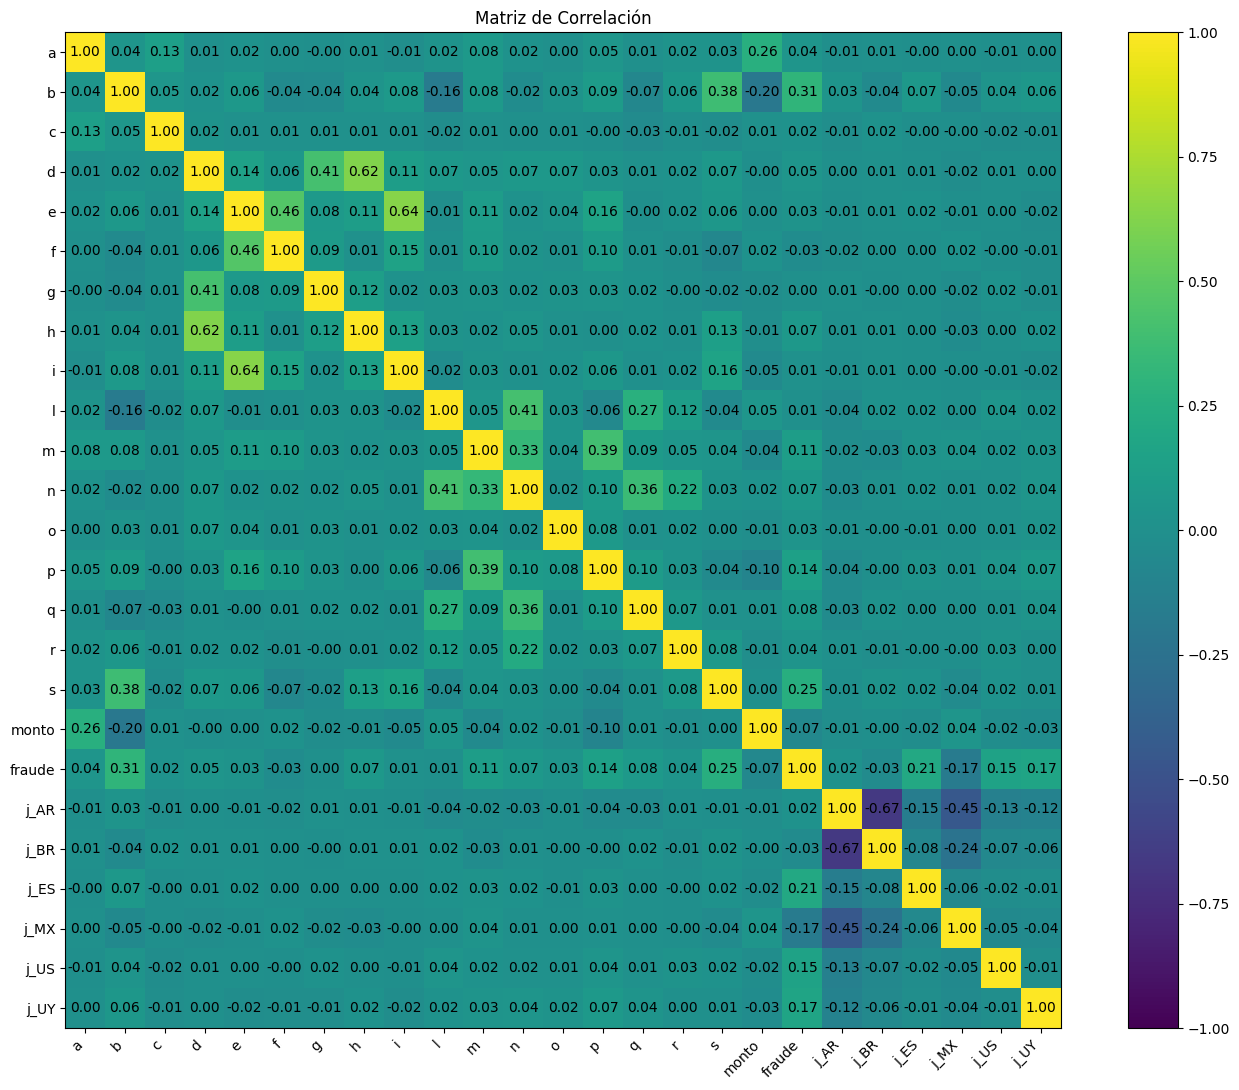

In [27]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(14, 11))

plt.imshow(corr_matrix, cmap='viridis', interpolation='none', vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Matriz de Correlación')

plt.tight_layout()
plt.show()

Realizemos otra matriz pero con seaborn para facilitar su visualización

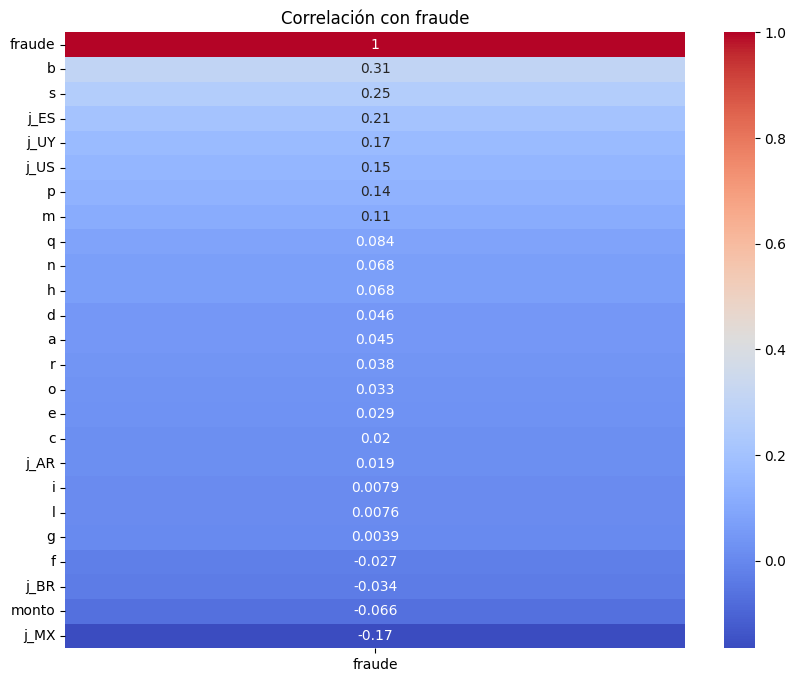

In [28]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])
correlation = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation[['fraude']].sort_values(by='fraude', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlación con fraude')
plt.show()

In [29]:
"""
import pandas as pd

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Extraer la correlación con la variable objetivo "fraude"
fraud_correlation = correlation_matrix['fraude']

# Identificar las columnas a eliminar (entre -0.030 y 0.030)
columns_to_drop = fraud_correlation[(fraud_correlation > -0.035) & (fraud_correlation < 0.035)].index

# Eliminar las columnas directamente del dataset original
data.drop(columns=columns_to_drop, inplace=True)

# Verificar las columnas eliminadas
print("Columnas eliminadas:", columns_to_drop.tolist())
"""

'\nimport pandas as pd\n\n# Calcular la matriz de correlación\ncorrelation_matrix = data.corr()\n\n# Extraer la correlación con la variable objetivo "fraude"\nfraud_correlation = correlation_matrix[\'fraude\']\n\n# Identificar las columnas a eliminar (entre -0.030 y 0.030)\ncolumns_to_drop = fraud_correlation[(fraud_correlation > -0.035) & (fraud_correlation < 0.035)].index\n\n# Eliminar las columnas directamente del dataset original\ndata.drop(columns=columns_to_drop, inplace=True)\n\n# Verificar las columnas eliminadas\nprint("Columnas eliminadas:", columns_to_drop.tolist())\n'

Como podemos observar hay muchas features con poca correlacion, al momento de implementar nuestro modelo para la prediccion podemos obtar por eliminar algunas para probar si mejora este.

In [30]:
data

,a,b,c,d,e,f,g,h,i,l,...,r,s,monto,fraude,j_AR,j_BR,j_ES,j_MX,j_US,j_UY
0,0.0,3.162278,224.180731,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,2.692582,6.124541,1,0,0,0,0,0,1
1,0.0,3.162278,170.334964,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,3.414674,2.860070,1,0,0,0,0,0,1
2,0.0,2.645751,9.591663,0.0,1.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,9.325771,3.736308,1,0,0,0,0,0,1
3,3.0,4.000000,224.207493,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.584298,9.678326,1,0,0,0,0,0,1
4,0.0,2.828427,90.443352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,5.095096,11.636151,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16875,0.0,1.732051,251.598887,0.0,1.000000,0.707107,0.0,0.0,0.0,1.0,...,0.0,9.259050,11.496521,1,0,1,0,0,0,0
16876,0.0,3.464102,28.722813,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,...,0.0,3.535534,5.132251,1,0,1,0,0,0,0
16877,1.0,1.732051,284.722672,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,4.915282,13.986779,1,0,1,0,0,0,0
16878,0.0,3.000000,631.167173,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,5.385165,6.080296,1,0,1,0,0,0,0


In [31]:
X = data.drop('fraude', axis=1)
y = data['fraude']

In [32]:
y.value_counts()

fraude
0    12236
1     4611
Name: count, dtype: int64

In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.24, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [34]:
len(X_train) , len(X_val) , len(X_test)

(12803, 2022, 2022)

In [35]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print("Distribución de clases en y_train antes del undersampling:")
print(y_train.value_counts())
print("\nDistribución de clases en y_train después del undersampling:")
print(pd.Series(y_train_resampled).value_counts())

Distribución de clases en y_train antes del undersampling:
fraude
0    9299
1    3504
Name: count, dtype: int64

Distribución de clases en y_train después del undersampling:
fraude
0    3504
1    3504
Name: count, dtype: int64


In [36]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1

)

# Ajustar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# Obtener los mejores parámetros y modelo
print("Mejores Parámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluar en el conjunto de validación
y_val_pred = best_model.predict(X_val)
print("Accuracy en Validación:", accuracy_score(y_val, y_val_pred))
print("Reporte de Clasificación:\n", classification_report(y_val, y_val_pred))

y_test_pred_xgboost = best_model.predict(X_test)
print("\nXGBoost Model Evaluation on Test Set:")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_xgboost))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgboost))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_xgboost))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Mejores Parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Accuracy en Validación: 0.7532146389713156
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82      1468
           1       0.54      0.73      0.62       554

    accuracy                           0.75      2022
   macro avg       0.71      0.74      0.72      2022
weighted avg       0.79      0.75      0.76      2022


XGBoost Model Evaluation on Test Set:
Test Accuracy: 0.7497527200791295
Test Confusion Matrix:
 [[1111  358]
 [ 148  405]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1469
           1       0.53      0.73      0.62       553

    accuracy                           0.75      2022
   macro avg       0.7

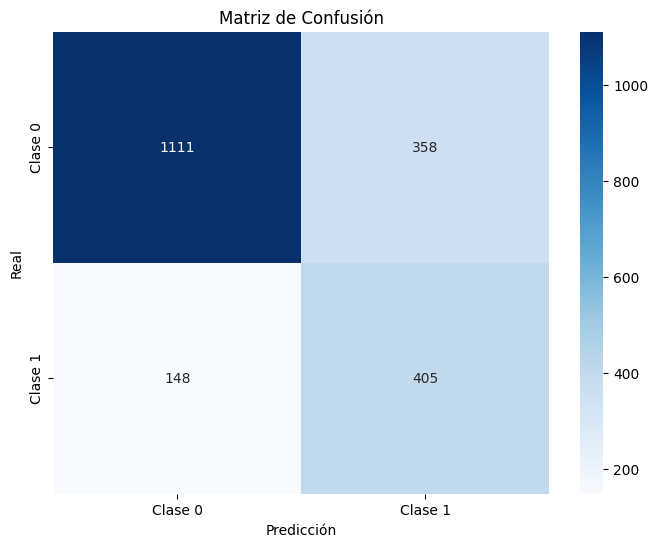

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred_xgboost)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

AUC: 0.8283274230515743


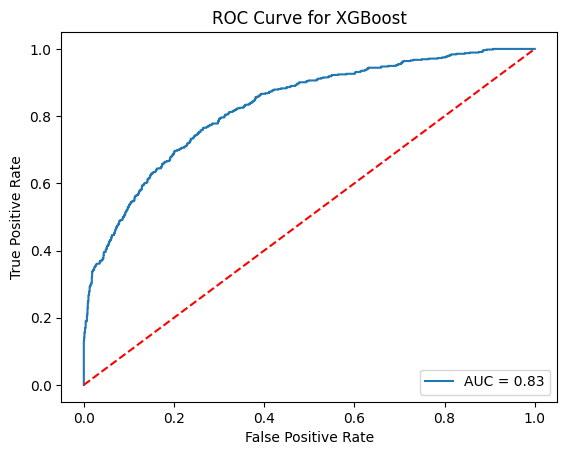

In [38]:
y_val_prob_xgboost = best_model.predict_proba(X_val)[:, 1]
auc_xgboost = roc_auc_score(y_val, y_val_prob_xgboost)
print("AUC:", auc_xgboost)

fpr_xgboost, tpr_xgboost, _ = roc_curve(y_val, y_val_prob_xgboost)

plt.plot(fpr_xgboost, tpr_xgboost, label=f"AUC = {auc_xgboost:.2f}")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="lower right")
plt.show()

   Feature  Importance
21    j_MX    0.127826
23    j_UY    0.117351
20    j_ES    0.111517
1        b    0.093859
22    j_US    0.082512
19    j_BR    0.040755
14       q    0.040545
16       s    0.033088
13       p    0.032822
0        a    0.031597
18    j_AR    0.029773
9        l    0.029055
10       m    0.025163
2        c    0.022371
5        f    0.020879
17   monto    0.020585
7        h    0.020317
3        d    0.019788
15       r    0.018774
12       o    0.018013
11       n    0.017802
8        i    0.017724
4        e    0.016799
6        g    0.011085


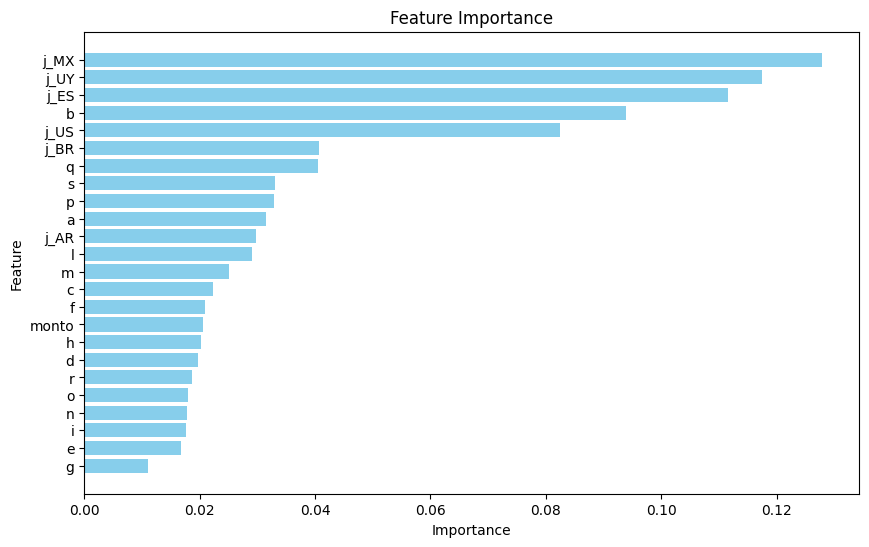

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener las importancias de las características
feature_importances = best_model.feature_importances_

# Crear un DataFrame para visualizarlo mejor
importance_df = pd.DataFrame({
    'Feature': X_train_resampled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
print(importance_df.head(25))

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invertir el eje para que la característica más importante esté arriba
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()